# GradCAM for SwinV2

In [2]:
import os
import glob
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from transformers import Swinv2ForImageClassification

c:\adam_kacmar\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found model files: ['../final-models/hp-swinv2-base\\model_lr0.0001_bs16.pth', '../final-models/hp-swinv2-base\\model_lr0.0001_bs32.pth', '../final-models/hp-swinv2-base\\model_lr0.0005_bs16.pth', '../final-models/hp-swinv2-base\\model_lr0.0005_bs32.pth', '../final-models/hp-swinv2-base\\model_lr1e-05_bs16.pth', '../final-models/hp-swinv2-base\\model_lr1e-05_bs32.pth']


C:\Users\Admin\AppData\Local\Temp\ipykernel_388\852370530.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location="cuda" if tor

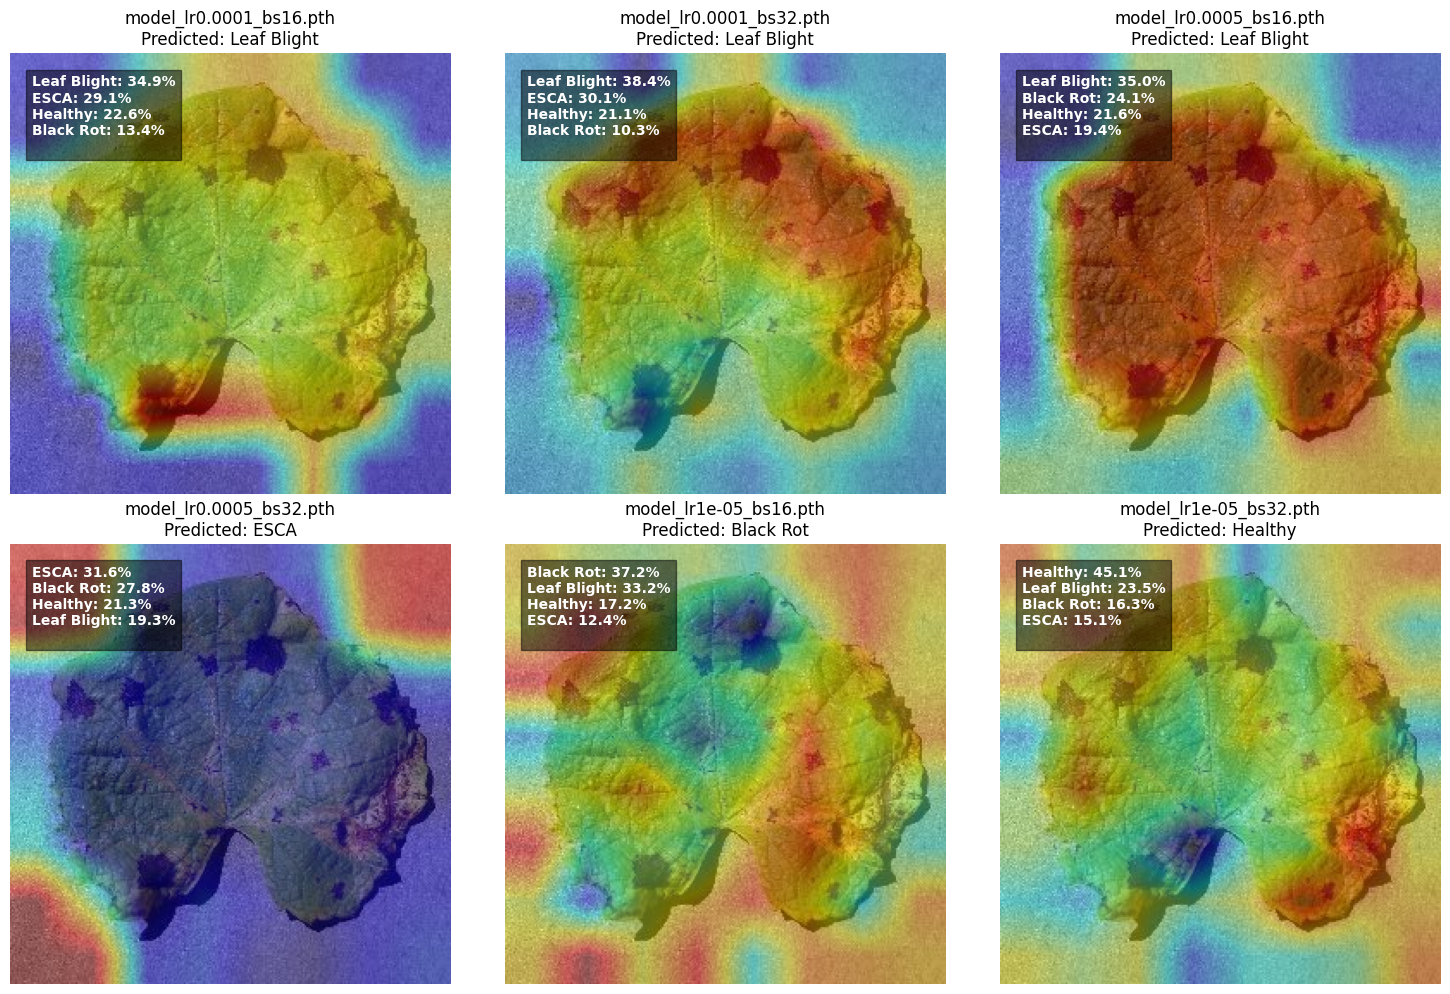

In [13]:
# Define class names for the 4 possible classes
class_names = ["Healthy", "Black Rot", "Leaf Blight", "ESCA"]

# Define the model loading function
def load_model(model_path, num_classes):
    model = Swinv2ForImageClassification.from_pretrained(
        "microsoft/swinv2-base-patch4-window8-256",
        ignore_mismatched_sizes=True  # Prevents errors due to classifier mismatch
    )
    # Load the checkpoint while ignoring the classifier layer
    checkpoint = torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = {k: v for k, v in checkpoint.items() if "classifier" not in k}  # Remove classifier weights
    model.load_state_dict(checkpoint, strict=False)

    # Reinitialize classifier head with the correct number of classes
    model.classifier = torch.nn.Linear(model.config.hidden_size, num_classes)
    
    # Move model to device and set to evaluation mode
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    return model

# Grad-CAM class for SwinV2 (adapted for transformer-based architectures)
class SwinV2GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        """ Extract the first element from the tuple output (if applicable). """
        if isinstance(output, tuple):  
            self.activations = output[0]  # Extract only the tensor
        else:
            self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        """ Extract the first element from the tuple gradients (if applicable). """
        if isinstance(grad_output, tuple):  
            self.gradients = grad_output[0]  # Extract only the tensor
        else:
            self.gradients = grad_output

    def generate_cam(self, input_tensor, class_idx):
        # Forward pass
        output = self.model(input_tensor)
        logits = output.logits
        score = logits[:, class_idx]

        # Backward pass
        self.model.zero_grad()
        score.backward(retain_graph=True)

        # Retrieve gradients and activations
        gradients = self.gradients.detach()
        activations = self.activations.detach()

        # Global Average Pooling along the token dimension
        weights = torch.mean(gradients, dim=1, keepdim=True)

        # Compute weighted activations
        cam = torch.sum(weights * activations, dim=2)
        cam = cam[0]

        # Compute spatial side length
        num_tokens = cam.shape[0]
        side = int(np.sqrt(num_tokens))
        if side * side != num_tokens:
            raise ValueError(f"Number of tokens ({num_tokens}) is not a perfect square.")

        # Reshape into a 2D spatial map
        cam = cam.reshape(side, side)

        # Normalize heatmap
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.cpu().numpy()


# Define the image preprocessing transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load a sample image (replace the path with your dataset image)
image_path = "../dataset/test/Leaf Blight/0a04146e-d973-40ad-ac79-3cc37b26fd58___FAM_L.Blight 4874_flipLR.JPG"
image_cv = cv2.imread(image_path)
if image_cv is None:
    raise ValueError(f"Image not found at path: {image_path}")
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image_cv)
input_tensor = transform(image).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

# Get list of model files from the hp-swinv2-base directory
model_files = sorted(glob.glob(os.path.join("../final-models/hp-swinv2-base", "*.pth")))
print("Found model files:", model_files)

num_classes = 4  # Use 4 classes: Healthy, Black Rot, Leaf Blight, ESCA

# Prepare subplots (2 rows x 3 columns for six models)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Loop through each model file and compute Grad-CAM visualization
for idx, model_file in enumerate(model_files):
    # Load model
    model = load_model(model_file, num_classes)

    # Select target layer for Grad-CAM (adjust if needed)
    target_layer = model.swinv2.encoder.layers[3].blocks[1].output
    

    grad_cam = SwinV2GradCAM(model, target_layer)
    
    # Get output logits and compute softmax probabilities
    with torch.no_grad():
        output = model(input_tensor).logits  # shape: [1, 4]
        probabilities = torch.softmax(output, dim=1)[0]  # shape: [4]
        predicted_class = output.argmax(dim=1).item()
    
    # Sort probabilities in descending order
    sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)
    
    # Create annotation text with the top 4 percentages; top is bolded
    annotation_text = ""
    for i in range(4):
        class_idx = sorted_indices[i].item()
        prob = sorted_probs[i].item()
        class_label = class_names[class_idx]
        annotation_text += f"{class_label}: {prob*100:.1f}%\n"

    # Generate Grad-CAM heatmap (using the top predicted class for visualization)
    heatmap = grad_cam.generate_cam(input_tensor, predicted_class)
    
    # Convert the PIL image to NumPy array for OpenCV processing
    image_np = np.array(image)
    
    # Resize heatmap to match image dimensions
    heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
    
    # Convert heatmap to 8-bit and apply a color map
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    
    # Convert original image from RGB to BGR (for OpenCV blending)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    
    # Blend the heatmap with the original image
    superimposed_img = cv2.addWeighted(image_bgr, 0.6, heatmap_color, 0.4, 0)
    
    # Convert back to RGB for display with Matplotlib
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    # Plot the result on the corresponding subplot
    ax = axes[idx]
    ax.imshow(superimposed_img_rgb)
    # Place the annotation text on the image (top-left corner in axes coordinates)
    ax.text(
        0.05, 0.95, annotation_text, transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', color='white', 
        bbox=dict(facecolor='black', alpha=0.5),
        fontweight='bold'  # Apply bold formatting
    )
    ax.set_title(f"{os.path.basename(model_file)}\nPredicted: {class_names[predicted_class]}")
    ax.axis("off")

    # Hide any extra subplots if there are fewer than expected
    for j in range(idx + 1, len(axes)):
        axes[j].axis("off")

plt.tight_layout()
plt.show()

In [8]:
for name, module in model.named_modules():
    print(name)


swinv2
swinv2.embeddings
swinv2.embeddings.patch_embeddings
swinv2.embeddings.patch_embeddings.projection
swinv2.embeddings.norm
swinv2.embeddings.dropout
swinv2.encoder
swinv2.encoder.layers
swinv2.encoder.layers.0
swinv2.encoder.layers.0.blocks
swinv2.encoder.layers.0.blocks.0
swinv2.encoder.layers.0.blocks.0.attention
swinv2.encoder.layers.0.blocks.0.attention.self
swinv2.encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp
swinv2.encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.0
swinv2.encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.1
swinv2.encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.2
swinv2.encoder.layers.0.blocks.0.attention.self.query
swinv2.encoder.layers.0.blocks.0.attention.self.key
swinv2.encoder.layers.0.blocks.0.attention.self.value
swinv2.encoder.layers.0.blocks.0.attention.self.dropout
swinv2.encoder.layers.0.blocks.0.attention.output
swinv2.encoder.layers.0.blocks.0.attention.outpu